# **Import/Preprocessing (training)**



## Import/CSV processing

In [1]:
import sys
!{sys.executable} -m pip install contractions

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
import seaborn as sns
import contractions as cot
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import re
import nltk
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
# Downloads library of stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
os.chdir("dataset/fake-news") # Changes the directory to the folder with the csv files

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aniketh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aniketh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
fn = pd.read_csv("Fake.csv")
tn = pd.read_csv("True.csv")
fn['truth'] = 0 # Makes a column of 0s marking the data false
tn['truth'] = 1 # Makes a column of 1s marking the data true

In [4]:
tn.drop_duplicates(inplace=True)
fn.drop_duplicates(inplace=True)

In [5]:
# Import and processing/cleaning of the dataframe
extra = pd.read_csv("politifact.csv")

# Drops the columns and rows that are not relevant
extra = extra.drop(columns=['Unnamed: 0', 'sources', 'sources_dates', 'sources_post_location', 'curator_name', 'curated_date', 'curators_article_title','curator_complete_article', 'curator_tags','sources_url'])
extra.drop_duplicates(inplace=True)
extra.dropna(inplace=True)

# Replaces the truths we want with their corresponding binary value
extra['fact'].replace(['false', "pants-fire"], 0, inplace=True)
extra['fact'].replace(['true', 'mostly-true'], 1, inplace=True)

# Drops the rows of the truths we don't need
extra.drop(extra.loc[extra['fact']=="half-true"].index, inplace=True)
extra.drop(extra.loc[extra['fact']=="barely-true"].index, inplace=True)
extra.drop(extra.loc[extra['fact']=="full-flop"].index, inplace=True)
extra.drop(extra.loc[extra['fact']=="half-flip"].index, inplace=True)
extra.drop(extra.loc[extra['fact']=="no-flip"].index, inplace=True)

extra.rename(columns={'sources_quote': 'title', 'fact':'truth'},inplace=True)

In [6]:
# Removes the \n's in the DataFrame
def remove_lines(text):
  text = text.strip("\n")
  return text
extra['title'] = extra['title'].apply(lambda x:remove_lines(x))

extra['text'] = extra['title']
extra.head()

,title,truth,text
0,Says Disneyland is enforcing a “no scream” pol...,0,Says Disneyland is enforcing a “no scream” pol...
1,Video “proves 100% that President Joe Biden is...,0,Video “proves 100% that President Joe Biden is...
2,“If you look at the average teacher pay compar...,1,“If you look at the average teacher pay compar...
5,“Pelosi’s $1.9 trillion bailout gives EVERY fe...,0,“Pelosi’s $1.9 trillion bailout gives EVERY fe...
6,“Black Lives Matter of Atlanta Charged with Wi...,0,“Black Lives Matter of Atlanta Charged with Wi...


In [7]:
# IMPORTANT: Balances the data; making the value higher will lean the program
# to predict true, lower is the opposite

fn = fn[:-4000]
fn.head()

,title,text,subject,date,truth
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [8]:
fn.rename(columns={0: "title", 1: "text", 2: "subject", 3: "date", 4: "truth" }, inplace=True)

In [9]:
news = pd.concat([tn, fn, extra], axis=0, ignore_index=True) # Combines the dataframes so its easier to work with


In [10]:
news.drop_duplicates(inplace=True) # Drops any leftover duplicates

In [11]:
news["truth"].value_counts()

truth
1    26850
0    26388
Name: count, dtype: int64

## Preprocessing


In [13]:
def remove_contractions(text):
  fixed_word = []
  for word in text.split():
    fixed_word.append(cot.fix(word))
  counter = 0
  for i in fixed_word:
    if i != fixed_word[0]:
      counter+=1
    if i == "you.S.":
      fixed_word[counter] = "u.s."
    if i == "yous":
      fixed_word[counter] = "u.s."
  fixed_whole =' '.join(fixed_word)
  return fixed_whole

# Applies the functions with lambda to do the stated function
news['title_wo_contra']=news['title'].apply(lambda x: remove_contractions(x))
news['text_wo_contra']=news['text'].apply(lambda x: remove_contractions(x))
news.head()

,title,text,subject,date,truth,title_wo_contra,text_wo_contra
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As YOU.S. budget fight looms, Republicans flip...",WASHINGTON (Reuters) - The head of a conservat...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,YOU.S. military to accept transgender recruits...,WASHINGTON (Reuters) - Transgender people will...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior YOU.S. Republican senator: 'Let Mr. Mue...,WASHINGTON (Reuters) - The special counsel inv...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...


In [14]:
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

# Applies the functions with lambda to do the stated function
news['title_wo_punct']=news['title_wo_contra'].apply(lambda x: remove_punctuation(x))
news['text_wo_punct']=news['text_wo_contra'].apply(lambda x: remove_punctuation(x))
news.head()

,title,text,subject,date,truth,title_wo_contra,text_wo_contra,title_wo_punct,text_wo_punct
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As YOU.S. budget fight looms, Republicans flip...",WASHINGTON (Reuters) - The head of a conservat...,As YOUS budget fight looms Republicans flip th...,WASHINGTON Reuters The head of a conservative...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,YOU.S. military to accept transgender recruits...,WASHINGTON (Reuters) - Transgender people will...,YOUS military to accept transgender recruits o...,WASHINGTON Reuters Transgender people will be...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior YOU.S. Republican senator: 'Let Mr. Mue...,WASHINGTON (Reuters) - The special counsel inv...,Senior YOUS Republican senator Let Mr Mueller ...,WASHINGTON Reuters The special counsel invest...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,FBI Russia probe helped by Australian diplomat...,WASHINGTON Reuters Trump campaign adviser Geo...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,Trump wants Postal Service to charge much more...,SEATTLEWASHINGTON Reuters President Donald Tr...


In [15]:
def remove_stopwords(text):
    text = text.split()
    text=[word for word in text if word not in stopword]
    text= ' '.join(text)
    return text

# Applies the functions with lambda to do the stated function
news['title_wo_stopwords'] = news['title_wo_punct'].apply(lambda x: remove_stopwords(x.lower()))
news['text_wo_stopwords'] = news['text_wo_punct'].apply(lambda x: remove_stopwords(x.lower()))

news.head()

,title,text,subject,date,truth,title_wo_contra,text_wo_contra,title_wo_punct,text_wo_punct,title_wo_stopwords,text_wo_stopwords
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As YOU.S. budget fight looms, Republicans flip...",WASHINGTON (Reuters) - The head of a conservat...,As YOUS budget fight looms Republicans flip th...,WASHINGTON Reuters The head of a conservative...,yous budget fight looms republicans flip fisca...,washington reuters head conservative republica...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,YOU.S. military to accept transgender recruits...,WASHINGTON (Reuters) - Transgender people will...,YOUS military to accept transgender recruits o...,WASHINGTON Reuters Transgender people will be...,yous military accept transgender recruits mond...,washington reuters transgender people allowed ...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior YOU.S. Republican senator: 'Let Mr. Mue...,WASHINGTON (Reuters) - The special counsel inv...,Senior YOUS Republican senator Let Mr Mueller ...,WASHINGTON Reuters The special counsel invest...,senior yous republican senator let mr mueller job,washington reuters special counsel investigati...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,FBI Russia probe helped by Australian diplomat...,WASHINGTON Reuters Trump campaign adviser Geo...,fbi russia probe helped australian diplomat ti...,washington reuters trump campaign adviser geor...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,Trump wants Postal Service to charge much more...,SEATTLEWASHINGTON Reuters President Donald Tr...,trump wants postal service charge much amazon ...,seattlewashington reuters president donald tru...


In [16]:
# Removes any formatted quotation marks that the remove contractions function
# didn't remove

def remove_quotemarks(text):
  text = text.replace('“', "")
  text = text.replace('’', "")
  text = text.replace('”', "")
  return text

news['filtered_title'] =news['title_wo_stopwords'].apply(lambda x:remove_quotemarks(x))
news['filtered'] =news['text_wo_stopwords'].apply(lambda x:remove_quotemarks(x))
news['filtered']

0        washington reuters head conservative republica...
1        washington reuters transgender people allowed ...
2        washington reuters special counsel investigati...
3        washington reuters trump campaign adviser geor...
4        seattlewashington reuters president donald tru...
                               ...                        
53233    house health care bill something like 2 percen...
53234    ronald reagan faced even worse recession curre...
53235          mccain campaign elaborate obamas ties acorn
53236    obama admitted cap trade plan would electricit...
53237    says could take stimulus money required univer...
Name: filtered, Length: 53238, dtype: object

In [17]:
# Deletes all the excess columns and sets the title equal to the preprocessed version

news["joined_title"] = news["filtered_title"]
news = news.drop(["title_wo_contra","title_wo_punct","title_wo_stopwords", "filtered_title"], axis=1)
news["joined_text"] = news["filtered"]
news = news.drop(["text_wo_contra","text_wo_punct","text_wo_stopwords", "filtered"], axis=1)
news.head(10)

,title,text,subject,date,truth,joined_title,joined_text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,yous budget fight looms republicans flip fisca...,washington reuters head conservative republica...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,yous military accept transgender recruits mond...,washington reuters transgender people allowed ...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,senior yous republican senator let mr mueller job,washington reuters special counsel investigati...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,fbi russia probe helped australian diplomat ti...,washington reuters trump campaign adviser geor...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,trump wants postal service charge much amazon ...,seattlewashington reuters president donald tru...
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017",1,white house congress prepare talks spending im...,west palm beach flawashington reuters white ho...
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017",1,trump says russia probe fair timeline unclear nyt,west palm beach fla reuters president donald t...
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017",1,factbox trump twitter dec 29 approval rating a...,following statements posted verified twitter a...
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017",1,trump twitter dec 28 global warming,following statements posted verified twitter a...
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017",1,alabama official certify senatorelect jones to...,washington reuters alabama secretary state joh...


## Visualization

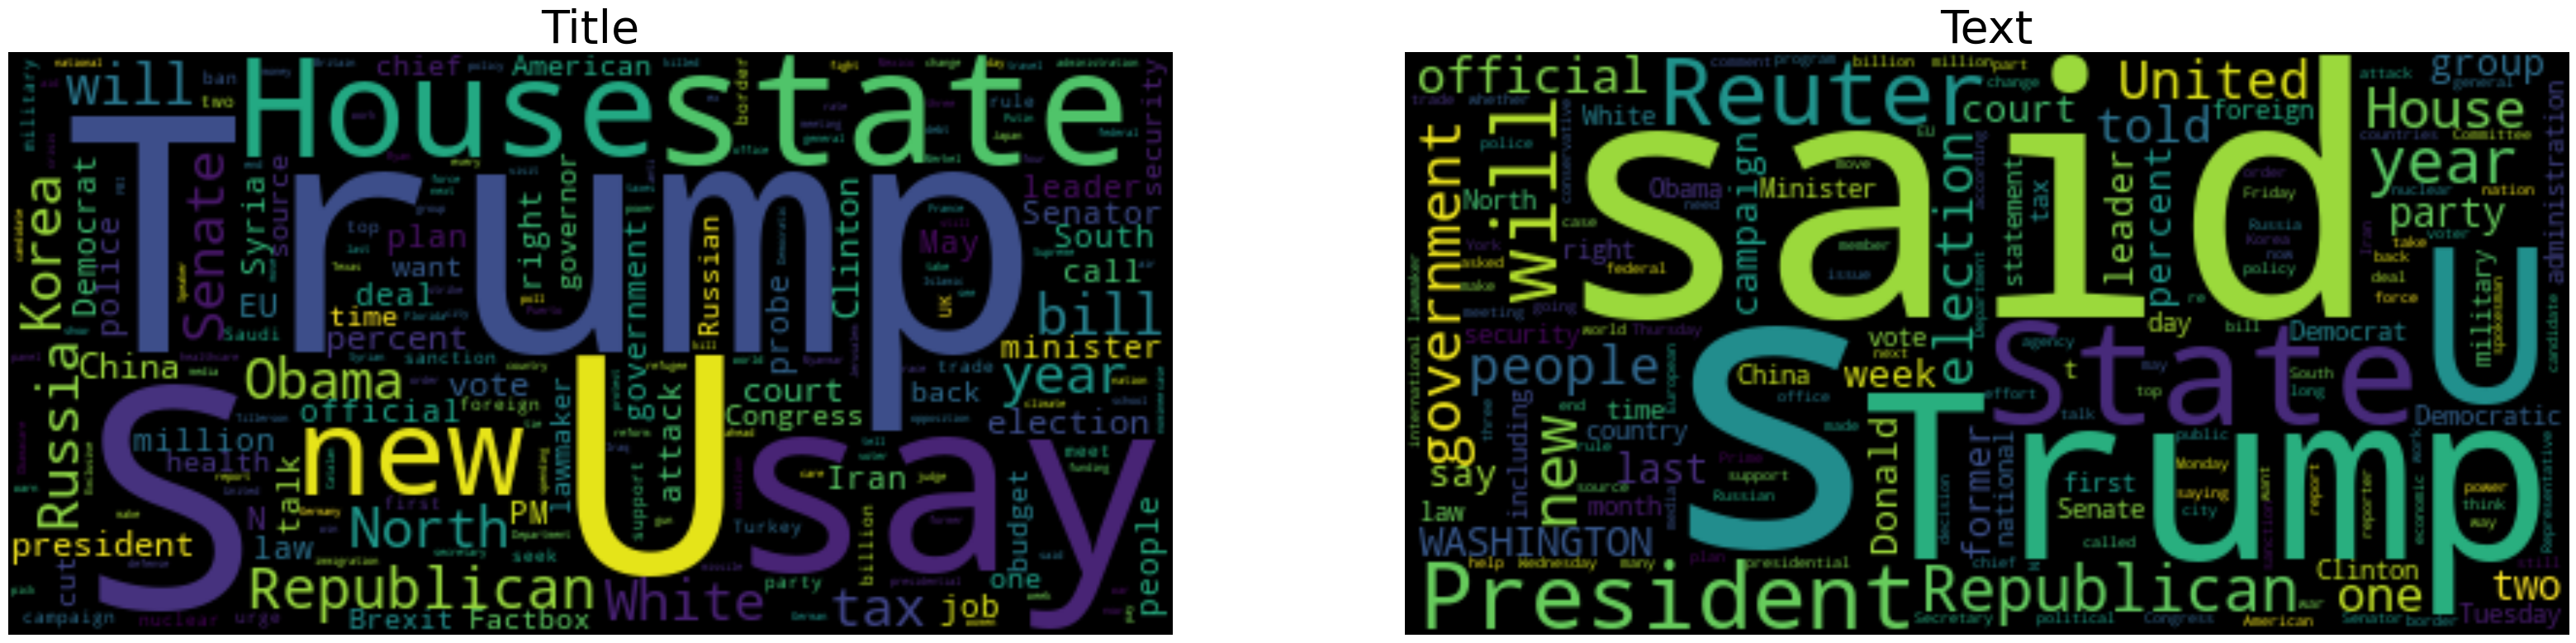

In [18]:
# Wordcloud of title, text in True news
import wordcloud
# Cleaned dataframe of True labels
df_true = news[news.truth == 1]

title_true = " ".join(tit for tit in df_true['title'])
text_true = " ".join(txt for txt in df_true['text'])

plt.figure(figsize=(40, 30))

# Title
title_cloud = wordcloud.WordCloud(collocations=False, background_color='black').generate(title_true)
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Title", fontsize=40)
plt.imshow(title_cloud, interpolation='bilinear')

# Title
text_cloud = wordcloud.WordCloud(collocations=False, background_color='black').generate(text_true)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Text", fontsize=40)
plt.imshow(text_cloud, interpolation='bilinear')


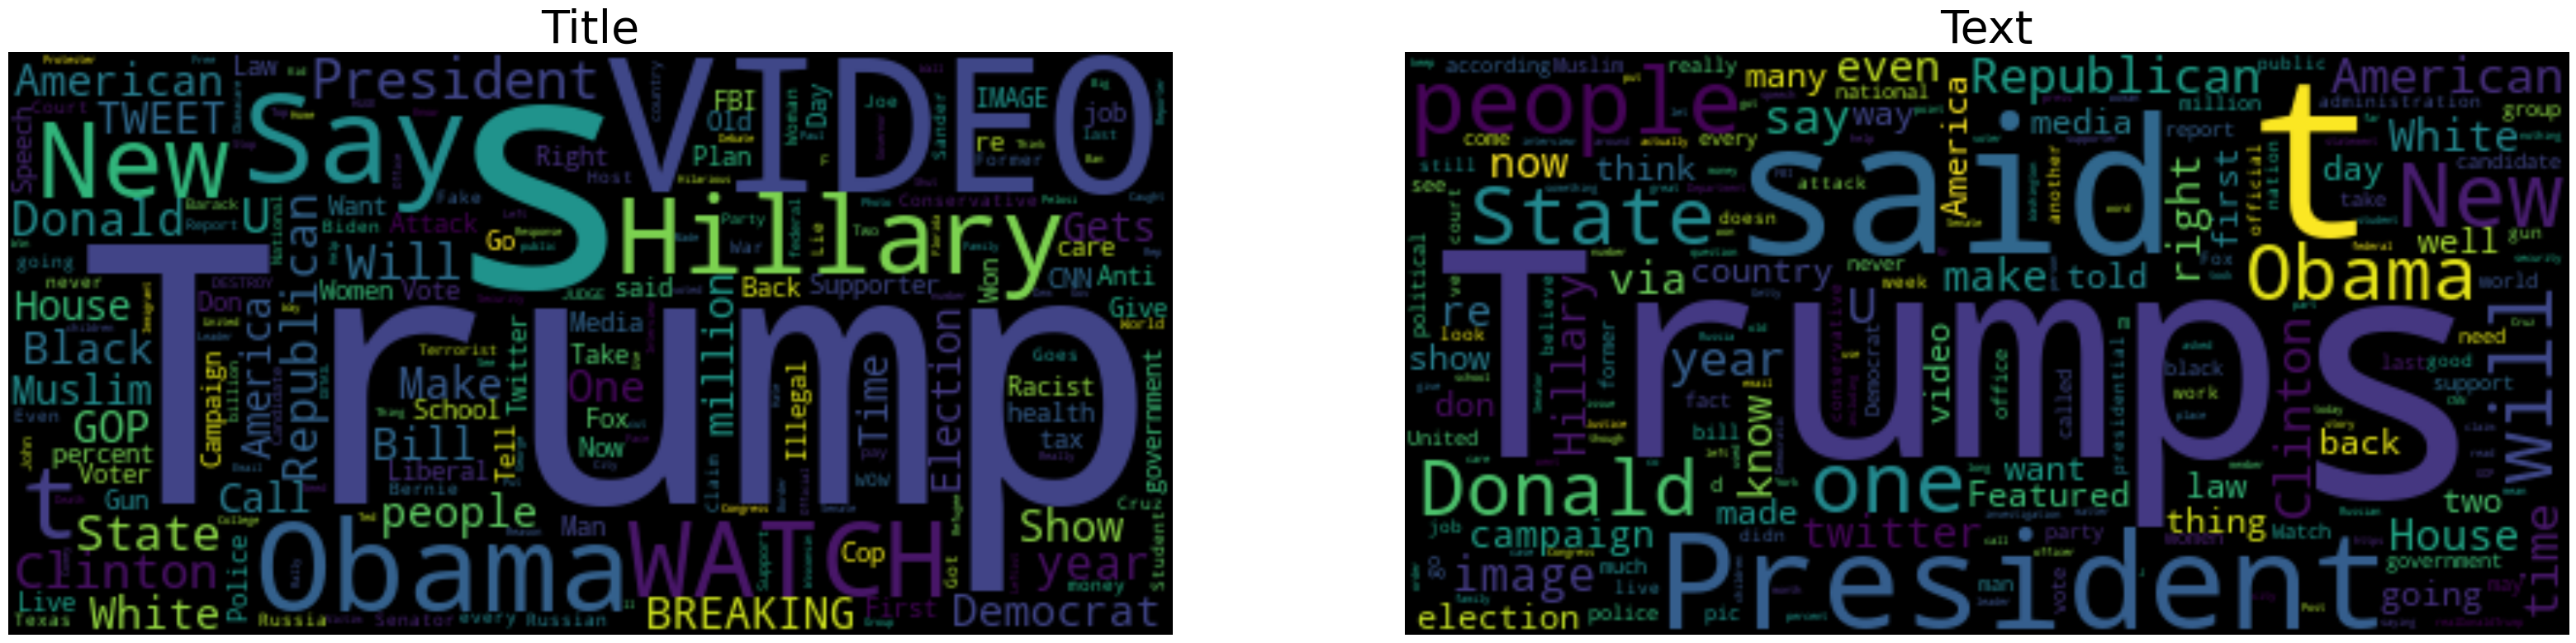

In [19]:
# Wordcloud of title, text in Fake news

# Cleaned dataframe of Fake labels

df_fake = news[news.truth == 0]

title_fake = " ".join(tit for tit in df_fake['title'])
text_fake = " ".join(txt for txt in df_fake['text'])

plt.figure(figsize=(40, 30))

# Title
title_cloud = wordcloud.WordCloud(collocations=False, background_color='black').generate(title_fake)
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Title", fontsize=40)
plt.imshow(title_cloud, interpolation='bilinear')

# Title
text_cloud = wordcloud.WordCloud(collocations=False, background_color='black').generate(text_fake)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Text", fontsize=40)
plt.imshow(text_cloud, interpolation='bilinear')

# **Model**

## **Vectorization/Model**

In [20]:
y = news['truth']
y = y.astype('int') # Some of the y values are "objects", so this converts it to int
X = news['joined_text']



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #Splits the data


In [21]:
from sklearn.naive_bayes import MultinomialNB

# Pipeline makes it easy to predict; no direct vectorization needed
# Can be all applied in one line

text_clf = Pipeline([('vect', TfidfVectorizer(ngram_range=(2,3), binary=True)),
                  ('tfidf', TfidfTransformer()),
                  ('clf', MultinomialNB())])


text_clf = text_clf.fit(X_train, y_train)


## **ML Model Scoring**

In [22]:
# Train score
text_clf.score(X_train, y_train)


0.9869452923221413

In [23]:
# Test score
text_clf.score(X_test, y_test)

0.8632607062359129

## **Precision and Recall Visualization**

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [25]:
y_predict_train = text_clf.predict(X_train)
y_predict_test = text_clf.predict(X_test)

<Axes: >

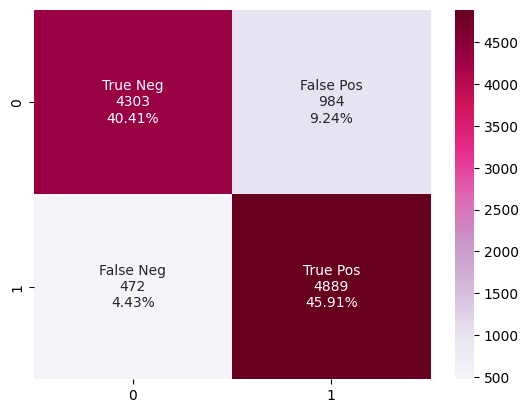

In [26]:
cm = confusion_matrix(y_test, y_predict_test)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='PuRd')

In [27]:
cr = classification_report(y_test, y_predict_test, output_dict= True)
cr = pd.DataFrame(cr).transpose()
cr

,precision,recall,f1-score,support
0,0.901152,0.813883,0.855297,5287.000000
1,0.832454,0.911957,0.870393,5361.000000
accuracy,0.863261,0.863261,0.863261,0.863261
macro avg,0.866803,0.862920,0.862845,10648.000000
weighted avg,0.866564,0.863261,0.862898,10648.000000


# **Input**

## **Input (manual)**

In [28]:
# Manual input
# Enter values into list
text_sample = ["We have a record 9.3 million job openings in the U.S.", "You can vote below the age of 18", "Hillary Clinton won presidency"]
df = pd.DataFrame(text_sample, columns= ['text'])
df2 = df.copy()
df

,text
0,We have a record 9.3 million job openings in t...
1,You can vote below the age of 18
2,Hillary Clinton won presidency


In [29]:
text_clf.predict(text_sample)

array([1, 1, 1])

## **Input (scraped)**

In [66]:
from bs4 import BeautifulSoup
import requests
import urllib

In [67]:
page = ""

# Type of news Input statement
# Try and except to make sure user gives an integer value
try:
  ton = int(input("What type of news to input into the model?:\n1: True\n2: Mostly True\n3: Half True\n4: Barely True\n5: False\n6: Extremely False\n"))
except ValueError:
  print("Enter a number!")
if ton == 1:
  page = "true"
elif ton == 2:
  page= 'mostly-true'
elif ton == 3:
  page= 'half-true'
elif ton == 4:
  page= 'barely-true'
elif ton == 5:
  page = 'false'
elif ton == 6:
  page = "pants-fire"
else:
  print("Not valid!")

# Append the sub-url that the user choses to the parent url

url = 'https://www.politifact.com/factchecks/list/?ruling='+ str(page)

print("Data source: "+ url)

Data source: https://www.politifact.com/factchecks/list/?ruling=true


In [68]:
def getdata(url):
    r = requests.get(url)
    return r.text

page = getdata(url)
soup = BeautifulSoup(page, "html.parser")


data = ''
lst = []

# Finds all the text that are located in the element that the claims are located
for data in soup.find_all("div",attrs={"class":"m-statement__quote"}):
  lst.append(data.get_text())

new_list = [s.replace("\n", "") for s in lst]
res = []

# Filters out duplicates
for i in new_list:
    if i not in res:
        res.append(i)

In [69]:
# Makes the list that will show the values of the truth in the DataFrame
if ton == 1:
  cat = ['true']
elif ton == 2:
  cat= ['mostly true']
elif ton == 3:
  cat= ['half true']
elif ton == 4:
  cat= ['barely true']
elif ton == 5:
  cat = ['false']
elif ton == 6:
  cat = ["extremely false"]
else:
  print("invalid")
cat*=len(res) #


# Converts the lists of text and truths of that text into a DataFrame
d = {'text':res,'truth':cat}
df = pd.DataFrame(data = d)

In [70]:
# Creates a copy so we can access the original later to display
df1 = df.copy()

# **Prediction**

## **Preprocessing (Input)**

same functions with slightly different changes

In [71]:
def remove_contractions(text):
  fixed_word = []
  for word in text.split():
    fixed_word.append(cot.fix(word))
  counter = 0
  for i in fixed_word:
    if i != fixed_word[0]:
      counter+=1
    if i == "you.S.":
      fixed_word[counter] = "u.s."
    if i == "yous":
      fixed_word[counter] = "u.s."
  fixed_whole =' '.join(fixed_word)
  return fixed_whole


df['text_wo_contra']=df['text'].apply(lambda x: remove_contractions(x))

In [72]:
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct
df['text_wo_punct']=df['text_wo_contra'].apply(lambda x: remove_punctuation(x))

In [73]:
def remove_stopwords(text):
    text = text.split()
    text=[word for word in text if word not in stopword]
    text= ' '.join(text)
    return text

df['text_wo_punct_wo_stopwords'] = df['text_wo_punct'].apply(lambda x: remove_stopwords(x.lower()))
df.head()

,text,truth,text_wo_contra,text_wo_punct,text_wo_punct_wo_stopwords
0,More than “200 dogs showed up and lined up aro...,true,More than “200 dogs showed up and lined up aro...,More than “200 dogs showed up and lined up aro...,“200 dogs showed lined around block” man’s 100...
1,“An 11-year-old boy saved the lives of two peo...,true,“An 11-year-old boy saved the lives of two peo...,“An 11yearold boy saved the lives of two peopl...,“an 11yearold boy saved lives two people day”
2,Infertility is treated differently than other ...,true,Infertility is treated differently than other ...,Infertility is treated differently than other ...,infertility treated differently issues often e...
3,"“Just last year,” Miami-Dade Public Schools “...",true,"“Just last year,” Miami-Dade Public Schools “h...",“Just last year” MiamiDade Public Schools “had...,“just last year” miamidade public schools “had...
4,"“For African American families in particular, ...",true,"“For African American families in particular, ...",“For African American families in particular t...,“for african american families particular home...


In [74]:
def remove_quotemarks(text):
  text = text.replace('“', "")
  text = text.replace('’', "")
  text = text.replace('”', "")
  return text
df['filtered'] =df['text_wo_punct_wo_stopwords'].apply(lambda x:remove_quotemarks(x))
df['filtered']

0     200 dogs showed lined around block mans 100th ...
1           an 11yearold boy saved lives two people day
2     infertility treated differently issues often e...
3     just last year miamidade public schools had 14...
4     for african american families particular homeo...
5     when basketball player football baseball playe...
6     if need girl scout cookies year local troop su...
7     joe biden older first day president ronald rea...
8     many law enforcement agencies submit hate crim...
9     wow county swing suburban voters wisconsin vot...
10    manhattan district attorney alvin bragg has do...
11    1 every 3 ron desantis spends comes federal go...
12    new yorks proposed limits natural gas building...
13    wisconsin nations top cranberry producer — fac...
14    biden drained americas strategic petroleum res...
15    historically spring elections including state ...
16    latina workers make 54 cents every dollar earn...
17    joe bidens 36 billion union pension fund t

In [75]:
df["joined"] = df["filtered"]
df = df.drop(["text_wo_contra","text_wo_punct","text_wo_punct_wo_stopwords", "filtered"], axis=1)
df.head(10)

,text,truth,joined
0,More than “200 dogs showed up and lined up aro...,true,200 dogs showed lined around block mans 100th ...
1,“An 11-year-old boy saved the lives of two peo...,true,an 11yearold boy saved lives two people day
2,Infertility is treated differently than other ...,true,infertility treated differently issues often e...
3,"“Just last year,” Miami-Dade Public Schools “...",true,just last year miamidade public schools had 14...
4,"“For African American families in particular, ...",true,for african american families particular homeo...
5,“When a basketball player or football or baseb...,true,when basketball player football baseball playe...
6,“If you need Girl Scout cookies this year and ...,true,if need girl scout cookies year local troop su...
7,“Joe Biden was older on his first day as presi...,true,joe biden older first day president ronald rea...
8,“Many law enforcement agencies didn’t submit t...,true,many law enforcement agencies submit hate crim...
9,"""WOW county swing suburban voters (in Wisconsi...",true,wow county swing suburban voters wisconsin vot...


## **Model, Vectorization, Prediction, and Confusion Matrix** (Scraped)

In [76]:
tmp = df["joined"]

text_sample = pd.Series.tolist(tmp) # Makes the sample text a list so it can be accessed


sample_predict = text_clf.predict(text_sample)

# The predicted values become a list so they can be inputed into the DataFrame

df1['predicted'] = sample_predict.tolist()



df1.head(6)

,text,truth,predicted
0,More than “200 dogs showed up and lined up aro...,true,1
1,“An 11-year-old boy saved the lives of two peo...,true,0
2,Infertility is treated differently than other ...,true,1
3,"“Just last year,” Miami-Dade Public Schools “...",true,1
4,"“For African American families in particular, ...",true,0
5,“When a basketball player or football or baseb...,true,0


In [77]:
df3 = df1.copy()

# Replaces the values with their corresponding binary value
df3['truth'].mask(df3['truth'] == 'false', 0, inplace=True)
df3['truth'].mask(df3['truth'] == 'barely true', 0, inplace=True)
df3['truth'].mask(df3['truth'] == 'extremely false', 0, inplace=True)
df3['truth'].mask(df3['truth'] == 'half true', 0, inplace=True)
df3['truth'].mask(df1['truth'] == 'true', 1, inplace=True)
df3['truth'].mask(df1['truth'] == 'mostly true', 1, inplace=True)
a = df3['truth'].tolist()
b = df3['predicted'].tolist()



In [78]:
true_negative = 0
false_negative = 0
true_positive = 0
false_positive = 0

# Gets the values of the confusion matrix
for i, j in zip(a, b):
  if i == j and i == 0:
    true_negative+=1
  elif i == j and i == 1:
    true_positive+=1
  elif i != j and j == 0:
    false_negative+=1
  elif i != j and j == 1:
    false_positive+=1


In [79]:
# Creates the blank confusion matrix
matrix = pd.DataFrame(columns=['negative', 'positive'], index=['negative', 'positive'])

# Sets the values of the previous cell to their correct position on the matrix
matrix['negative']['negative'] = true_negative
matrix['positive']['positive'] = true_positive
matrix['negative']['positive'] = false_negative
matrix['positive']['negative'] = false_positive

# NOTE: Columns is predicted and indexs are actual value
matrix

,negative,positive
negative,0,0
positive,13,17


In [80]:
df1['predicted'].mask(df1['predicted'] == 0, 'false', inplace=True)
df1['predicted'].mask(df1['predicted'] == 1, 'true', inplace=True)
df1.head()

,text,truth,predicted
0,More than “200 dogs showed up and lined up aro...,true,true
1,“An 11-year-old boy saved the lives of two peo...,true,false
2,Infertility is treated differently than other ...,true,true
3,"“Just last year,” Miami-Dade Public Schools “...",true,true
4,"“For African American families in particular, ...",true,false


In [81]:
df1.iloc[3][0]

' “Just last year,” Miami-Dade Public Schools “had over 14,000 new children, 10,000 of which came from four countries of Cuba, Nicaragua, Venezuela and Haiti.”'